# Week 6 - Machine Learning and Casual Inference

In this notebook we will walk through methods that combine machine learning and causal inference in contexts where the main goal is to isolate a causal effect.

The main purpose of this notebook is to learn how to practically implement the methods you saw in class and to think about the scenarios in which these methods are useful.


## Estimating the Gender Wage Gap and Child Penalty

In the first 3 exercises we will try to estimate the **gender wage gap** and the effect of having a child on earnings, which have been a hot topic in economic research and among policyamkers for a while now. 

We will do this using data from the 2018 Current Population Survey (CPS) in the US. In particular, we will use the version of the CPS provided by the [NBER](https://www.nber.org).

The *raw* regressions of reference is the following: 

$$y_i = \beta_0 + \beta_1 female_i + \varepsilon_i$$

$$y_i = \delta_0 + \delta_1 child_i + \varepsilon_i$$

where $y_i$ is one of the labor outcomes that we will define below and $female_i$ is a dummy for being a woman, and $child_i$ is a dummy equal to 1 if individual $i$ has a child.

**Suppose that $y_i$ is hourly wage, what can be a threat that threat a causal interpretation of $\beta_1$?**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col


style.use("fivethirtyeight")

In [2]:
df = pd.read_stata("https://www.nber.org/morg/annual/morg18.dta")
#we take subset of data just to reduce computation time
df = df.sample(30000, replace=False, random_state=0)
pd.read_stata('https://www.nber.org/morg/annual/morg18.dta', iterator=True).variable_labels()

{'hhid': 'Household ID',
 'intmonth': 'Interview Month',
 'hurespli': 'Line Number of Respondent',
 'hrhtype': 'Household Type',
 'minsamp': 'Month in sample (4 & 8 are departing)',
 'hrlonglk': 'Longitudinal Link Indicator',
 'hrsample': 'Sample indentifier',
 'hrhhid2': 'Household ID (partII)',
 'serial': 'Serial suffix',
 'hhnum': 'Household number',
 'stfips': 'State FIPS code',
 'cbsafips': 'Metropolitan CBSA FIPS code',
 'county': 'FIPS County Code',
 'centcity': 'Principal/Central city status',
 'smsastat': 'Metropolitan status code',
 'icntcity': 'Individual principal/central city code',
 'smsa04': 'Metropolitan Area (CBSA) size code',
 'relref95': 'Relationship to reference person',
 'age': 'Age',
 'spouse': "Spouse's line number",
 'sex': 'Sex',
 'grade92': 'Highest grade completed',
 'race': 'Race',
 'ethnic': 'Ethnicity',
 'lineno': "Person's Line Number",
 'famnum': 'Family number',
 'pfamrel': 'Primary family relationship',
 'marital': 'Marital status',
 'prpertyp': 'Type

In [4]:
df.head()

,hhid,intmonth,hurespli,hrhtype,minsamp,hrlonglk,hrsample,hrhhid2,serial,hhnum,...,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc,docc00,dind02
103153,150909100105603,May,1.0,Civilian male primary individual,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0801,08011,1,1,...,700,697,0,0,0,0,0,NaN,Business and financial operations occupations,Professional and Technical services
76648,505760912076673,March,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0811,08111,1,1,...,698,695,0,0,0,0,0,12.0,NaN,NaN
51433,481462012350753,February,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0701,07011,1,1,...,697,694,0,0,0,0,0,NaN,Management occupations,Agriculture
75550,106518879410166,March,2.0,Husband/wife primary fam (neither in Armed For...,MIS 8,MIS 2-4 Or MIS 6-8 (link To,0611,06111,1,1,...,698,683,0,0,0,0,0,11.0,NaN,NaN
284643,466023401171104,December,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0901,09011,1,1,...,707,704,0,1,1,0,1,13.0,Management occupations,Membership associations and organizations


In [5]:
# d variable:
df["female"] = (df['sex']==2).astype('int')
df['child'] = (df['ownchild']>0).astype('int')

# y variable:
df["log_earn"] = np.log(df['earnwke'])
df["log_earn"][np.isinf(df['log_earn'])] = np.nan

# hours (usual):
df["log_uhours"] = np.log(df['uhourse'])
df["log_uhours"][np.isinf(df['log_uhours'])] = np.nan

# hours (last week):
df["log_hourslw"] = np.log(df.hourslw)
df["log_hourslw"][np.isinf(df.log_hourslw)] = np.nan

# wage = earnigns / hours
df["log_wageu"] = df['log_earn'] - df['log_uhours']

In [6]:
print(df.female.value_counts())
print(df.child.value_counts())

1    15624
0    14376
Name: female, dtype: int64
0    22622
1     7378
Name: child, dtype: int64


**How would you try to isolate the effect of gender or of having a child on wages? Which of the techniques that we saw in class would you use here?**

## Propensity Score Matching

In this part we will focus on the estimation of the gender wage gap. We will focus on hourly wage ($log\_wageu$) as main outcome of interest.

In [7]:
olsf = smf.ols("log_wageu~female", df).fit(cov_type='hc1')
ols2f = smf.ols('log_wageu ~ female + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)', df).fit(cov_type='hc1')

print(summary_col([olsf, ols2f], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['female']))


                                                                                                                         log_wageu I    log_wageu II  
------------------------------------------------------------------------------------------------------------------------------------------------------
female                                                                                                                   -0.169      -0.110           
                                                                                                                         (0.010)     (0.012)          
C(cbsafips)[T.10180]                                                                                                                 -0.191           
                                                                                                                                     (0.080)          
C(occ2012)[T.5140.0]                                                                         

**How would you interpret the coefficient on female?**

### Prepare variables for ML

In [8]:
df.shape

(30000, 104)

In [9]:
cont_vars = ['log_hourslw', 'age']
cat_vars = ['race', 'cbsafips', 'smsastat', 'grade92', 'unionmme','unioncov', 'ind02','occ2012', 'marital', 'smsa04', 'prcitshp', 'chldpres']
df2 = df.dropna(subset=['female', 'log_wageu'] + cont_vars + cat_vars)
for var in cat_vars:
    df2[var] = df2[var].astype('str')
df2.shape

(13052, 104)

In [10]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df2[cat_vars] = encoder.fit_transform(df2[cat_vars])
df2[cont_vars] = df2[cont_vars].astype('float32')

In [11]:
D = df2['female']
y = df2['log_wageu']
X = df2[cat_vars + cont_vars]

### Calculate Propensity Scores

Recall that propensity scores are just the probability of being treated (in this case of being women) given the values of the predictors:

<center>$\hat{Female}(X) = Pr(Female | X)$</center>

But this is basically a prediction problem that we can solve using machine learning.

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_a, X_b, D_a, D_b, y_a, y_b= train_test_split(X, D, y, test_size=0.5)
X_atr, X_ats, X_btr, X_bts, D_atr, D_ats, D_btr, D_bts = train_test_split(X_a, X_b, D_a, D_b, test_size=0.2)

xgb_a = XGBClassifier()
xgb_b = XGBClassifier()

xgb_a.fit(X_atr, D_atr)
D_hat_a = xgb_a.predict(X_ats)
xgb_b.fit(X_btr, D_btr)
D_hat_b = xgb_b.predict(X_bts)


print('Accuracy Score on Test Set')
print('Sample A: %f' % accuracy_score(D_hat_a, D_ats))
print('Sample B: %f' % accuracy_score(D_hat_b, D_bts))

[13:38:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score on Test Set
Sample A: 0.721286
Sample B: 0.727412


We calculate propensity scores by cross-predicting the probability of being female across the two samples.

In [13]:
pscore_b = xgb_a.predict_proba(X_b)[:,1]
pscore_a = xgb_b.predict_proba(X_a)[:,1]

D = D_a.append(D_b) 
y = y_a.append(y_b)
pscores = np.concatenate((pscore_a, pscore_b))
data = np.array([y,D,pscores]).T
pscores_df = pd.DataFrame(data=data,columns=['log_hourslw',"female", "pscore"])

pscores_df.head()

,log_hourslw,female,pscore
0,3.608835,1.0,0.973240
1,2.197225,0.0,0.015077
2,2.639057,0.0,0.656226
3,2.995732,1.0,0.479483
4,3.223863,1.0,0.675769


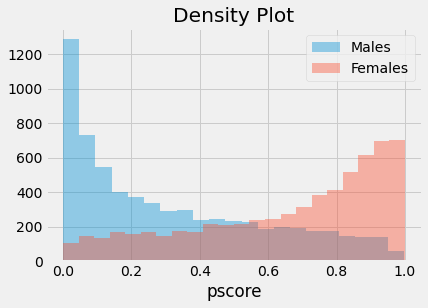

In [14]:
sns.distplot(pscores_df.query("female==0")["pscore"], kde=False, label="Males")
sns.distplot(pscores_df.query("female==1")["pscore"], kde=False, label="Females")
plt.title("Density Plot")
plt.legend();

### Estimate Gender Wage Gap using Propensity Scores

In [15]:
pscores_df['bins'] = pd.cut(pscores_df['pscore'], bins = 50, labels=range(1,51))
pscores_df['bins'] = pscores_df['bins'].astype('str')
pscores_df.head()

,log_hourslw,female,pscore,bins
0,3.608835,1.0,0.973240,49
1,2.197225,0.0,0.015077,1
2,2.639057,0.0,0.656226,33
3,2.995732,1.0,0.479483,24
4,3.223863,1.0,0.675769,34


**What are we comparing within each bin?**

In [16]:
pscores_df = pscores_df.groupby(['bins', 'female']).mean()
pscores_df.head()

log_hourslw    pscore
bins female                       
1    0.0        2.968205  0.009422
     1.0        2.884388  0.011806
10   0.0        3.037388  0.190209
     1.0        2.933259  0.190188
11   0.0        3.070984  0.210145

In [17]:
pscores_df['diffs'] = np.nan 

for idx in pscores_df.index.levels[0]:
    pscores_df.diffs[idx][1] = pscores_df.log_hourslw[idx][1] - pscores_df.log_hourslw[idx][0]
    
ate_df = pscores_df.dropna()
ate_df.head()

,,log_hourslw,pscore,diffs
bins,female,,,
1,1.0,2.884388,0.011806,-0.083817
10,1.0,2.933259,0.190188,-0.104129
11,1.0,3.089585,0.209037,0.018601
12,1.0,3.091239,0.230726,-0.081225
13,1.0,3.046542,0.250618,-0.112703


In [18]:
ATE = ate_df.diffs.mean()
print(ATE)

-0.13408734969168953


**How does this compare to the previous estimate?**

## Double Machine Learning

In this second exercise we will focus on the effect of having a child on hourly wages for women. The regression we will try to estimate is the following: 

$$log\_wageu_i=\delta_0 + \delta_1 child_i+ f(x_i) +\varepsilon_i$$ 


**Generally, in which cases would you use double ML? In your opinion is this a good setting?**

In [19]:
df_fem = df[df['female']==1]

olsc = smf.ols("log_wageu ~ child", df_fem).fit(cov_type='hc1')
ols2c = smf.ols('log_wageu ~ child + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)', df_fem).fit(cov_type='hc1')

print(summary_col([olsc, ols2c], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['child']))


                                                                                                                         log_wageu I log_wageu II
-------------------------------------------------------------------------------------------------------------------------------------------------
child                                                                                                                    0.079       0.051       
                                                                                                                         (0.015)     (0.014)     
C(cbsafips)[T.10180]                                                                                                                 -0.160      
                                                                                                                                     (0.086)     
C(occ2012)[T.2850.0]                                                                                                       

**How would you interpret the coefficient on having a child?**

### Prepare Variables for ML

In [20]:
cont_vars = ['log_hourslw', 'age']
cat_vars = ['race', 'cbsafips', 'smsastat', 'grade92', 'unionmme','unioncov', 'ind02','occ2012']
df2 = df_fem.dropna(subset=['log_wageu', 'child'] + cont_vars + cat_vars)
for var in cat_vars:
    df2[var] = df2[var].astype('str')
    
print(df2.shape)
print(df2.child.value_counts())

(6413, 104)
0    4294
1    2119
Name: child, dtype: int64


In [21]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df2[cat_vars] = encoder.fit_transform(df2[cat_vars])
df2[cont_vars] = df2[cont_vars].astype('float32')

In [22]:
D = df2['child']
y = df2['log_wageu']
X = df2[cat_vars + cont_vars]

### Step 1. Predict $y$ and $D$ from $X$ using Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, mean_squared_error)

rfc_a = RandomForestClassifier(n_estimators=100, max_depth =30, random_state=42)
rfc_b = RandomForestClassifier(n_estimators=100,  max_depth =30, random_state=42)

rfr_a = RandomForestRegressor(n_estimators=100, max_depth =30, random_state=42)
rfr_b = RandomForestRegressor(n_estimators=100,  max_depth =30, random_state=42)


X_a, X_b, D_a, D_b, y_a, y_b= train_test_split(X, D, y, test_size=0.5)
X_atr, X_ats, D_atr, D_ats, y_atr, y_ats, = train_test_split(X_a, D_a, y_a, test_size=0.2)
X_btr, X_bts, D_btr, D_bts, y_btr, y_bts = train_test_split(X_b, D_b, y_b, test_size=0.2)

#### Train the models

In [24]:
rfc_a.fit(X_atr, D_atr)
D_hat_a = rfc_a.predict(X_ats)
rfc_b.fit(X_btr, D_btr)
D_hat_b = rfc_b.predict(X_bts)


print('F1 Score on Test Set')
print('Sample A: %f' % f1_score(D_hat_a, D_ats))
print('Sample B: %f' % f1_score(D_hat_b, D_bts))

F1 Score on Test Set
Sample A: 0.642857
Sample B: 0.557292


In [25]:
rfr_a.fit(X_atr, y_atr)
y_hat_a = rfr_a.predict(X_ats)
rfr_b.fit(X_btr, y_btr)
y_hat_b = rfr_b.predict(X_bts)


print('RMSE on Test Set')
print('Sample A: %f' % np.sqrt(mean_squared_error(y_hat_a, y_ats)))
print('Sample B: %f' % np.sqrt(mean_squared_error(y_hat_b, y_bts)))

RMSE on Test Set
Sample A: 0.470730
Sample B: 0.469284


#### Cross predict $D$ and $y$

In [26]:
D_hat_a = rfc_b.predict(X_a)
D_hat_b = rfc_a.predict(X_b)

y_hat_a = rfr_b.predict(X_a)
y_hat_b = rfr_a.predict(X_b)

### Step 2. Compute residuals for having a child and hourly wages

Recall that residuals for variable $Z$ are computed in the following way: 
 
 $$\tilde Z_i = Z_i - \hat Z_i$$

In [27]:
D = D_a.append(D_b) 
Dhat = np.concatenate((D_hat_a, D_hat_b))
y = y_a.append(y_b)
yhat = np.concatenate((y_hat_a, y_hat_b))
data = np.array([y,D,yhat, Dhat]).T
df_dml = pd.DataFrame(data=data,columns=['y',"D", "yhat", 'Dhat'])

df_dml['log_wageu'] = df_dml.y - df_dml.yhat
df_dml['child'] = df_dml.D - df_dml.Dhat

df_dml.head()

,y,D,yhat,Dhat,log_wageu,child
0,2.047693,0.0,2.240098,0.0,-0.192405,0.0
1,2.788181,0.0,3.057251,1.0,-0.269070,-1.0
2,2.956472,1.0,2.606831,1.0,0.349641,0.0
3,2.442347,0.0,2.811158,0.0,-0.368811,0.0
4,1.750937,0.0,2.241072,0.0,-0.490135,0.0


### Step 3. Run a Regression of the residualized variables to compute DML estimats

In [28]:
dml = smf.ols('log_wageu ~ child', df_dml).fit(cov_type='hc1')
print(summary_col([olsc, ols2c, dml], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['child']))


                                                                                                                         log_wageu I log_wageu II log_wageu III
---------------------------------------------------------------------------------------------------------------------------------------------------------------
child                                                                                                                    0.079       0.051        -0.012       
                                                                                                                         (0.015)     (0.014)      (0.012)      
C(cbsafips)[T.10180]                                                                                                                 -0.160                    
                                                                                                                                     (0.086)                   
C(occ2012)[T.2850.0]                   

## Heterogenous Treatment Effects

In this part we will again assume that the treatment is having a child and we want to investigate the characteristics of women whose earnings are most affected by having a child.

### Step 1. Divide the sample in "treated" and "untreated"

In [29]:
df_treat = df2.loc[df2['child']==1]
df_control = df2.loc[df2['child']==0]

### Step 2. Train two models to predict $y$ based on the covariates, one for each datasets using XGBoost

In [30]:
from xgboost import XGBRegressor

Xt_train, Xt_test, yt_train, yt_test = train_test_split(df_treat[cat_vars + cont_vars], df_treat['log_wageu'], test_size=0.3)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(df_control[cat_vars + cont_vars], df_control['log_wageu'], test_size=0.3)

xgbr_treat = XGBRegressor()
xgbr_control = XGBRegressor()

xgbr_treat.fit(Xt_train, yt_train)
xgbr_control.fit(Xc_train, yc_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Step 3. Form predicted outcomes for each datapoint in the test set, using both models

In [31]:
test_set = Xt_test.append(Xc_test)

yhat_treat = xgbr_treat.predict(test_set)
yhat_control = xgbr_control.predict(test_set)

### Step 4. Compute the treatment effect for each observation using the predicted values

In [32]:
test_set['treat_effect'] = yhat_treat - yhat_control
test_set.head()

,race,cbsafips,smsastat,grade92,unionmme,unioncov,ind02,occ2012,log_hourslw,age,treat_effect
214737,0.0,202.0,0.0,13.0,0.0,0.0,92.0,68.0,3.688879,38.0,-0.043401
139873,0.0,0.0,1.0,8.0,0.0,0.0,114.0,249.0,3.688879,46.0,0.052112
213920,8.0,150.0,0.0,15.0,0.0,0.0,175.0,99.0,3.912023,45.0,0.749995
247340,0.0,0.0,1.0,13.0,0.0,0.0,110.0,102.0,3.663562,46.0,0.051260
180847,8.0,209.0,0.0,11.0,0.0,0.0,41.0,327.0,3.688879,49.0,-0.136094


In [33]:
test_set = test_set.sort_values('treat_effect', axis=0)
test_set.head()

,race,cbsafips,smsastat,grade92,unionmme,unioncov,ind02,occ2012,log_hourslw,age,treat_effect
163232,0.0,256.0,0.0,12.0,0.0,0.0,91.0,7.0,3.688879,58.0,-1.937297
151959,0.0,0.0,1.0,10.0,0.0,0.0,53.0,311.0,2.995732,63.0,-1.772317
34688,0.0,51.0,0.0,8.0,0.0,0.0,192.0,83.0,0.000000,74.0,-1.420213
1231,5.0,259.0,0.0,8.0,0.0,0.0,165.0,174.0,3.218876,33.0,-1.365004
111291,8.0,53.0,0.0,15.0,0.0,0.0,73.0,65.0,3.688879,62.0,-1.354399


We can also visualize the most important predictors for having a large treatment effect.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

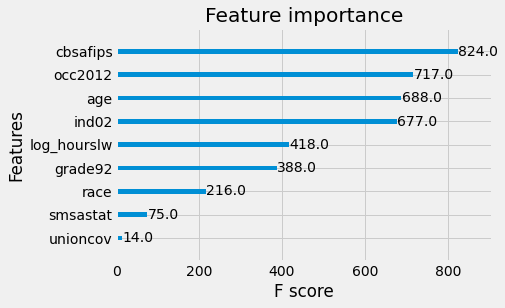

In [34]:
from xgboost import plot_importance

xgb = XGBRegressor()
xgb.fit(test_set[cat_vars + cont_vars], test_set['treat_effect'])

plot_importance(xgb)

**What would be an ideal setting to investigate heterogenous treatmetn effects?**

## Synthetic Control Method

In this part we will replicate the analysis of the paper from class on the anti-tobacco legislation ([Abadie et al., 2010]()). We will investigate the effect of this law implemented in California in 1988 on cigarettes sales. The (raw) reference regression is the following:

$$sales_s = \beta_0 + \beta_1 law_s + \varepsilon_s$$

where $sales_s$ is per capita cigarettes sales in sales $s$ and $law_s$ is a dummy equal to 1 if the law was passed in that state. 

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/OscarEngelbrektson/SyntheticControlMethods/3f496b36ed46c4e5c1e08ce6e903013e6eeb29df/examples/datasets/smoking_data.csv')
df['california'] = (df['state']=='California').astype('int')
df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california
0,Alabama,1970.0,89.8,NaN,NaN,0.178862,39.6,0
1,Alabama,1971.0,95.4,NaN,NaN,0.179928,42.7,0
2,Alabama,1972.0,101.1,9.498476,NaN,0.180994,42.3,0
3,Alabama,1973.0,102.9,9.550107,NaN,0.182060,42.1,0
4,Alabama,1974.0,108.2,9.537163,NaN,0.183126,43.1,0


In [3]:
ols = smf.ols('cigsale ~ california', data =df).fit(cov_type='hc1')
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cigsale   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     21.41
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           4.10e-06
Time:                        11:16:28   Log-Likelihood:                -5924.9
No. Observations:                1209   AIC:                         1.185e+04
Df Residuals:                    1207   BIC:                         1.186e+04
Df Model:                           1                                         
Covariance Type:                  hc1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    119.5329      0.950    125.778      0.000     117.670     121.395
california   -24.9458      5.391     -4.628      0.000     -35.511     -14.380
==============================================================================
Omnibus:                      398.791   Durbin-Watson:                   0.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1666.836
Skew:                           1.522   Prob(JB):                         0.00
Kurtosis:                       7.881   Cond. No.                         6.33
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

**Can we interpret the coefficient on california as causal? Why?**

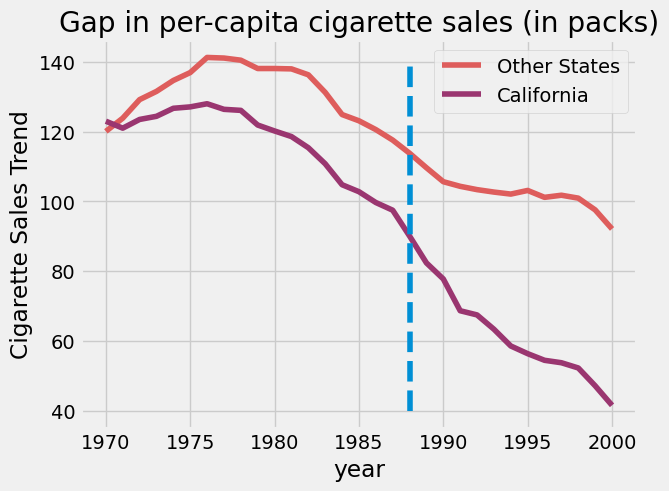

In [4]:
palette = sns.color_palette("flare", 2)
plot = sns.lineplot(data=df, x='year', y='cigsale', hue='california', palette=palette, ci=None)

plot.vlines(x=1988, ymin=40, ymax=140, linestyle="dashed")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plot.legend_.set_title('')
new_labels = ['Other States', 'California']
for t, l in zip(plot.legend_.texts, new_labels):
    t.set_text(l)

**Could we use a difference in differences design in this context?**

You can find the refernece material for the python package on the synthetic control method at this [link](https://github.com/OscarEngelbrektson/SyntheticControlMethods)

In [5]:
from SyntheticControlMethods import Synth
del df['california'] # deletes dummy variable created above

sc = Synth(df, outcome_var='cigsale', id_var='state', time_var='year', treatment_period=1989, # time of first observation after the treatment took place
     treated_unit='California', n_optim=10, # Number of different initialization values for which the optimization is run.
     pen='auto') #  Penalization coefficient 

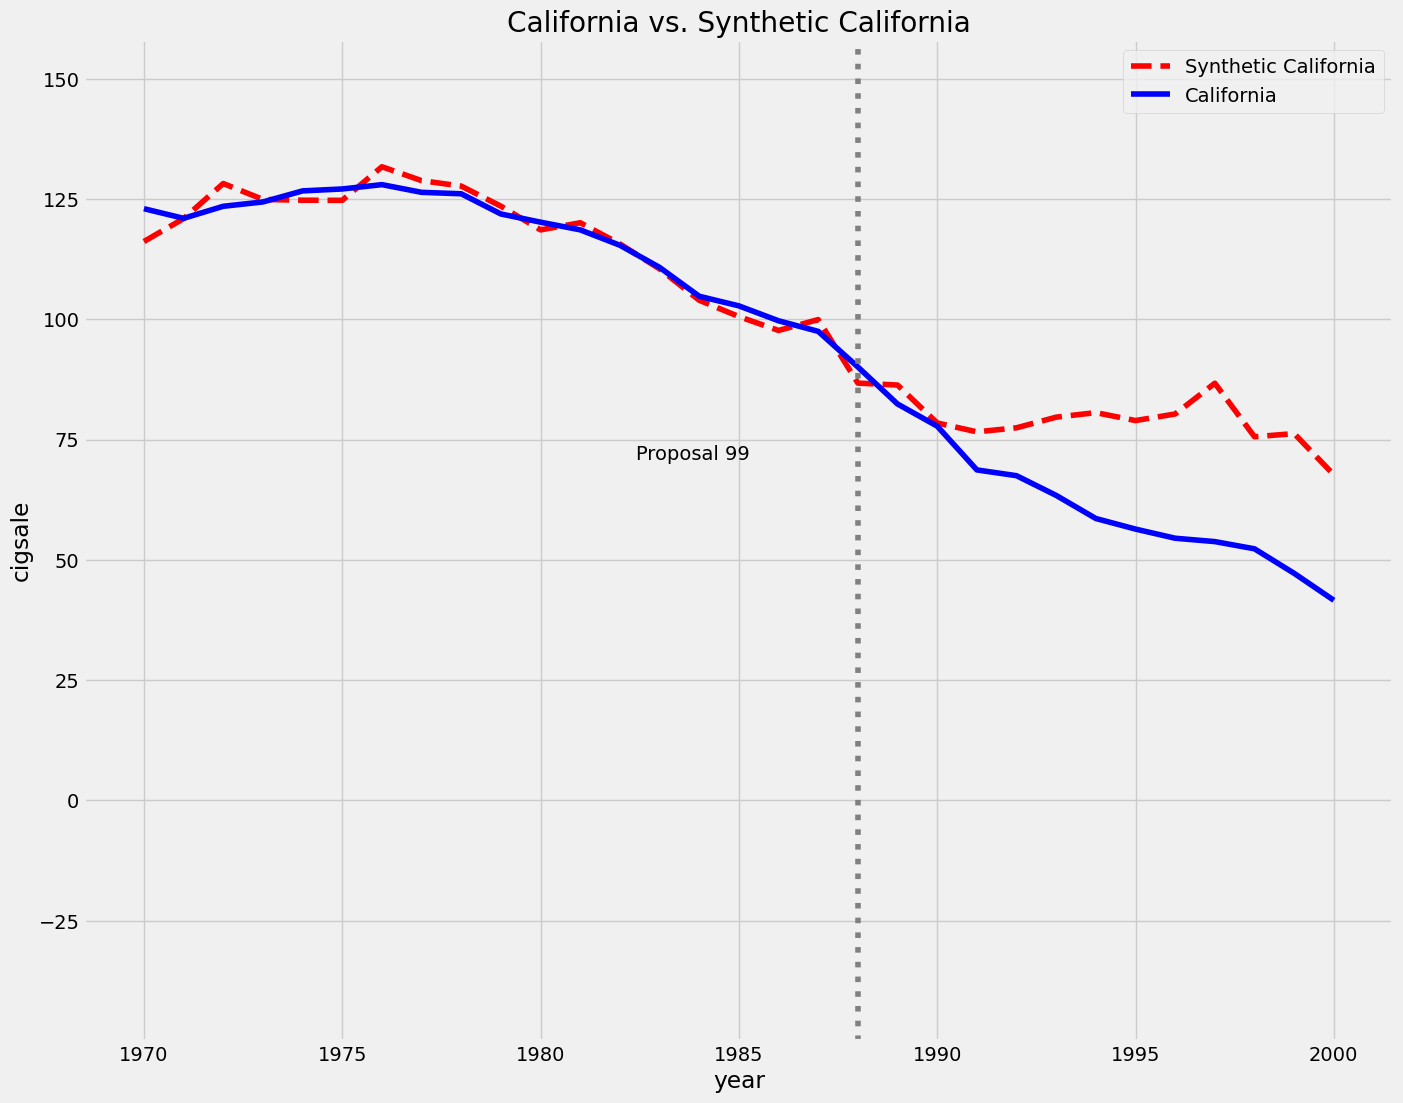

In [6]:
sc.plot(["original"], treated_label="California", 
            synth_label="Synthetic California", treatment_label="Proposal 99")

In [7]:
print(sc.original_data.weight_df)

                 Weight
New Hampshire  0.253153
Utah           0.746847
